# Usage: S-R trend analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lisphilar/covid19-sir/blob/master/example/usage_phases.ipynb)

Here, how to set phases in scenario analysis will be explained. As an example, use the records in India.

## Preperation

In [1]:
!pip install covsirphy --upgrade

In [2]:
import covsirphy as cs
cs.__version__

'2.22.0'

In [3]:
# Load datasets
loader = cs.DataLoader("../input")
jhu_data = loader.jhu()

In [4]:
# Create instance of `Scenario` class
snl = cs.Scenario(country="India", province=None)
snl.register(jhu_data)

In [5]:
# Summarize main scenario
snl.summary()

""
Type
Start
End
Population


Note:  
This is empty because no phases are registered. Term "phase" means a sequential dates in which the parameters of SIR-derived models are fixed. The details will be explained later.

Just for demonstration, we will fix the first/end date of the records here. This is un-necessary for your analysis when you want to use all records.
Today means the reference date to determine whether a phase is a past phase or a future phase.

In [6]:
# Fix the first/last date of the records and today
# today must be in the range of (first_date, last_date).
# Default: None means automatically specified (min/max will be used)
snl.timepoints(first_date="01Mar2020", last_date="31Dec2020", today="16Jul2020")
# Check dates
print(snl.first_date)
print(snl.last_date)
print(snl.today)
# Summarize (Empty because no phases are registered)
snl.summary()

01Mar2020
31Dec2020
16Jul2020


""
Type
Start
End
Population


## Set phases with S-R trend analysis
How can we set phases?

Here, we will use "S-R trend analysis" explained in [S-R trend analysis section in "Kaggle: COVID-19 data with SIR model"](https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model#S-R-trend-analysis). $S$ (Susceptible) and $R$ (Recovered) show the following relationship in SIR-derived models. $S_{(R)}$ means $S$ as a function of $R$.

$$S_{(R)} = N e^{-a R}$$

where $N$ is total population and $a=\cfrac{\beta}{N \gamma}$ is a constant.  
This leads to
$$\log S_{(R)} = - a R + \log N$$

$\log S$ decreases constantly with increase of $R$, when the records follow a SIR-derived model and the parameter values of the model are constant. With logarithmic y-axis scale, plot of $(x, y) = (R, S)$ shows a line. 

The slope of the line may change when the parameter values ($\beta$ and $\gamma$) are changed. To detect the dates when the parameter values were changed, we will find the change points of $\log S$ as a function of $R$, using [ruptures: change point detection in Python](https://github.com/deepcharles/ruptures) via `Scenario.trend()`. We call the period from a change point to the next change point as a "phase" in this analysis.

We can select the algorithm and models to detect the change points from "Binseg-normal" (default), "Pelt-rbf", "Binseg-rbf", "BottomUp-rbf", "BottomUp-normal". Please refer to [the documentation of ruptures package](https://centre-borelli.github.io/ruptures-docs/). Please use `algo` argument of `Scenario.trend()`.

Additionally, we can specify the minimum size of phases with `min_size` (7 days as default) argument of `Scenario.trend()`.

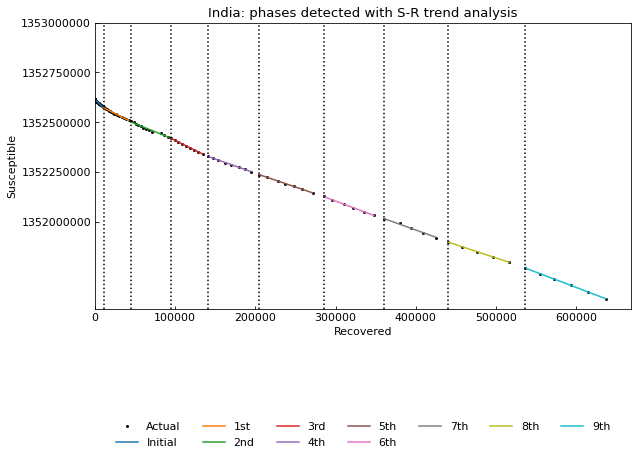

,Type,Start,End,Population
0th,Past,01Mar2020,02May2020,1352617328
1st,Past,03May2020,19May2020,1352617328
2nd,Past,20May2020,31May2020,1352617328
3rd,Past,01Jun2020,09Jun2020,1352617328
4th,Past,10Jun2020,17Jun2020,1352617328
5th,Past,18Jun2020,24Jun2020,1352617328
6th,Past,25Jun2020,30Jun2020,1352617328
7th,Past,01Jul2020,05Jul2020,1352617328
8th,Past,06Jul2020,10Jul2020,1352617328
9th,Past,11Jul2020,16Jul2020,1352617328


In [7]:
# Set phase with S-R trend analysis
snl.trend(algo="Pelt-rbf", min_size=5)
snl.summary()

## Disable/enable phases
If no need to analyse some phases, we can disable the phase with `Scenario.disable()`. Here, we will disable the 0th and 1st phase.

In [8]:
snl.disable(phases=["0th", "1st"]).summary()

,Type,Start,End,Population
2nd,Past,20May2020,31May2020,1352617328
3rd,Past,01Jun2020,09Jun2020,1352617328
4th,Past,10Jun2020,17Jun2020,1352617328
5th,Past,18Jun2020,24Jun2020,1352617328
6th,Past,25Jun2020,30Jun2020,1352617328
7th,Past,01Jul2020,05Jul2020,1352617328
8th,Past,06Jul2020,10Jul2020,1352617328
9th,Past,11Jul2020,16Jul2020,1352617328


The 0th and 1st phase are not shown in the summary.

When we want to enable some phase, we use `Scenario.eanble()`. Here, we will enable 1st phase. The 0th phase remain disabled.

In [9]:
snl.enable(phases=["1st"]).summary()

,Type,Start,End,Population
1st,Past,03May2020,19May2020,1352617328
2nd,Past,20May2020,31May2020,1352617328
3rd,Past,01Jun2020,09Jun2020,1352617328
4th,Past,10Jun2020,17Jun2020,1352617328
5th,Past,18Jun2020,24Jun2020,1352617328
6th,Past,25Jun2020,30Jun2020,1352617328
7th,Past,01Jul2020,05Jul2020,1352617328
8th,Past,06Jul2020,10Jul2020,1352617328
9th,Past,11Jul2020,16Jul2020,1352617328


## Remove un-necessary change points manually
The slope of the 5th phase seems to equal to that of 4th phase. Here, we will combine 4th phase and 5th phase here and reset phase names.

||before|after|
|---|---|---|
|4th|10Jun - 17Jun|10Jun - **24Jun**|
|5th|18Jun - **24Jun**|25Jun - 30Jun|

In [10]:
snl.combine(phases=["4th", "5th"])
snl.summary()

,Type,Start,End,Population
1st,Past,03May2020,19May2020,1352617328
2nd,Past,20May2020,31May2020,1352617328
3rd,Past,01Jun2020,09Jun2020,1352617328
4th,Past,10Jun2020,24Jun2020,1352617328
5th,Past,25Jun2020,30Jun2020,1352617328
6th,Past,01Jul2020,05Jul2020,1352617328
7th,Past,06Jul2020,10Jul2020,1352617328
8th,Past,11Jul2020,16Jul2020,1352617328


## Separate phases manually
Because point of $(x, y) = (S, R)$ jumped on 29May2020, we will separete the 1st phase with this change point and reset phase names.

||before|after|
|---|---|---|
|2nd|20May - **31May**|20May - 28May|
|3rd|01Jun - 09Jun|<u>29May</u> - **31May**|

In [11]:
snl.separate("29May2020").summary()

,Type,Start,End,Population
1st,Past,03May2020,19May2020,1352617328
2nd,Past,20May2020,28May2020,1352617328
3rd,Past,29May2020,31May2020,1352617328
4th,Past,01Jun2020,09Jun2020,1352617328
5th,Past,10Jun2020,24Jun2020,1352617328
6th,Past,25Jun2020,30Jun2020,1352617328
7th,Past,01Jul2020,05Jul2020,1352617328
8th,Past,06Jul2020,10Jul2020,1352617328
9th,Past,11Jul2020,16Jul2020,1352617328


## Add phases one by one
In the previous sections, we started with S-R trend analysis. We can create phases without this analysis when you have a new idea to find change points.

In [12]:
# Clear all phases
snl.clear(include_past=True).summary()

""
Type
Start
End
Population


In [13]:
# Set 0th phase to set the start date of 1st phase
snl.add(end_date="19May2020")
# Add 1st phase and disable 0th phase
snl.add(end_date="28May2020").disable(phases=["0th"])
# Add 2nd phase
snl.add(end_date="02Jun2020")
# Add 3rd phase
snl.add(end_date="11Jun2020")
# Add 4th phase
snl.add(end_date="29Jun2020")
# Add 5th phase to the last of the records
snl.add().summary()

,Type,Start,End,Population
1st,Past,20May2020,28May2020,1352617328
2nd,Past,29May2020,02Jun2020,1352617328
3rd,Past,03Jun2020,11Jun2020,1352617328
4th,Past,12Jun2020,29Jun2020,1352617328
5th,Past,30Jun2020,16Jul2020,1352617328
